In [0]:
%matplotlib inline

In [0]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from itertools import count
from sklearn.model_selection import ShuffleSplit
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import trange
import xgboost as xgb


env = gym.make('CartPole-v0')

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Goal

In this notebook I'm exploring Q Learning for the Cart-Pole problem.

Main question I wanted to answer is how does a neural net compare to XGB.

## Neural net 

It is set up in a different way than standard Q Learning - instead of learning online it does epochs over whole memory over a set number of steps. XGBoost can't be trained online, so it's more adequate to try them out in similar settings.

In [0]:
class QFA():  # Q - function approximator
  def fresh(): pass
  def fit(memory, params): pass
  def predict(memory, params): pass

class NQFA():  # N of them

  def __init__(self, qfas, params, fa_type='nn'):
    self.models = qfas
    self.params = params
    self.fa_type = fa_type
    self.n_models = len(qfas)
    self.curr_model = 0
    self.memory = None  # {'states': None, 'actions': None, 'rewards': None, 'next_states': None}
    self.memory_pending = {'states': [], 'actions': [], 'rewards': [], 'next_states': []}
    for model in self.models:
      model.fresh()  # to try different params without re-defining models
  
  def update(self):  # update memory, fit
    self.curr_model = (self.curr_model + 1) % self.n_models
    if self.memory is None:
      self.memory = dict()
      for key in self.memory_pending.keys():  # this is why I chose dict over namedtuple
        self.memory[key] = torch.cat(self.memory_pending[key]).to(device)
    else:
      for key in self.memory_pending.keys():
        self.memory[key] = torch.cat(self.memory_pending[key] + [self.memory[key]]).to(device)
    for key in self.memory_pending.keys():
      self.memory[key] = self.memory[key][-self.params['memory_limit']:]
    return fit(self.fa_type, self.models[self.curr_model],
               self.models[(self.curr_model+1)%self.n_models], self.memory, self.params)

  def memorize(self, state, action, reward, next_state):
    assert state.shape[0] == 1 and action.shape == (1,1) and reward.shape == (1,) and next_state.shape[0] == 1
    self.memory_pending['states'] += [state]
    self.memory_pending['actions'] += [action]
    self.memory_pending['rewards'] += [reward]
    self.memory_pending['next_states'] += [next_state]
  
  def decide(self, state):  # greedy action
    return self.models[self.curr_model].predict(state).max(1)[1].view(1, 1)

  def reset(self):
    for model in self.models:
      model.fresh()
    self.memory = None  
    self.memory_pending = {'states': [], 'actions': [], 'rewards': [], 'next_states': []}


In [0]:
class QNN(nn.Module, QFA):
  def __init__(self, input_dim, mid_dim, action_dim):
    super().__init__()
    self.dense_1 = nn.Linear(input_dim, mid_dim)
    self.dense_2 = nn.Linear(mid_dim, action_dim)
    self.to(device)
        
  def forward(self, x):
    x = F.leaky_relu(self.dense_1(x))
    x = F.leaky_relu(self.dense_2(x))
    return x    

  def fresh(self):
    self.dense_1.reset_parameters()
    self.dense_2.reset_parameters()

  def predict(self, x):
    return self(x)

def fit(fa_type, *args):
  if fa_type == 'nn':
    return nn_fit(*args)
  elif fa_type == 'bst':
    return bst_fit(*args)
  
def nn_fit(policy_net, target_net, memory, hyper_params, restart=True):
  train_i, eval_i = next(ShuffleSplit(1, .2).split(memory['states']))
  batch_size = hyper_params['batch_size']
  if len(train_i) < batch_size:
    return False
  opt = optim.Adam(policy_net.parameters(), hyper_params['lr'])
  loss = 0

  for i in range(hyper_params['max_epochs']):
    ep_len = len(train_i) // batch_size
    for j in range(ep_len):
      batch_i = train_i[j*batch_size : (j+1)*batch_size]

      non_final_next_state_mask = ~torch.isnan(memory['next_states'][batch_i]).max(1)[0].to(torch.bool)
      # prediction
      state_action_values = policy_net(memory['states'][batch_i]).gather(1, memory['actions'][batch_i])
      # bootstrap
      next_state_values = torch.ones(batch_size, device=device) * hyper_params['death_reward']      
      next_state_values[non_final_next_state_mask] = target_net(memory['next_states'][batch_i][non_final_next_state_mask]).max(1)[0].detach()  # max(1) here is precisely greedy
      # target
      expected_state_action_values = ((next_state_values * hyper_params['gamma']) + memory['rewards'][batch_i])

      # Compute Huber loss
      loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
      # Optimize the model
      opt.zero_grad()
      loss.backward()
      
      for param in policy_net.parameters():
          param.grad.data.clamp_(-1, 1)
      opt.step()

    total_loss = 0
    with torch.no_grad():
      non_final_next_state_mask = ~torch.isnan(memory['next_states'][eval_i]).max(1)[0].to(torch.bool)
      # prediction
      state_action_values = policy_net(memory['states'][eval_i]).gather(1, memory['actions'][eval_i])
      # bootstrap
      next_state_values = torch.ones(len(eval_i), device=device) * hyper_params['death_reward']        
      next_state_values[non_final_next_state_mask] = target_net(memory['next_states'][eval_i][non_final_next_state_mask]).max(1)[0].detach()  # max(1) here is precisely greedy
      # target
      expected_state_action_values = ((next_state_values * hyper_params['gamma']) + memory['rewards'][eval_i])

      # Compute Huber loss
      loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

  if loss > hyper_params['loss_ceiling'] and restart:
    # restarting
    policy_net.fresh()
#    hyper_params_2 = hyper_params
#    hyper_params_2['loss_ceiling'] *= 2
    new_loss = nn_fit(policy_net, target_net, memory, hyper_params, restart=False)
  return loss


  

In [0]:
q = QNN(4, 8, 2)

Batch_size is a tradeoff between start of training and training speed at the end - might want to increase it in the mean time

Max_epochs = 2 for training speed

Gamma = 1 works as the task is episodic

Death_reward = -10: death is further penalised because I want continuous weak pressure on leaky part of relus, on states that were close to loosing

Lr is later optimised

Loss_ceiling = 10, for restarts if the loss explodes, but it really shouldn't


In [0]:
params = {
    'batch_size': 128, 'max_epochs': 2, 'target_loss': 1, 'gamma': 1.0, 'death_reward': -10, 'lr': .01, 'loss_ceiling': 10, 'memory_limit': 10000
}

In [0]:
q1 = QNN(4,6,2)
q2 = QNN(4,8,2)

In [0]:
nqfa = NQFA([q1, q2], params)

In [0]:
EPS_START = 0.9
EPS_END = 0.00
EPS_DECAY = 100
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()

# Get number of actions from gym action space



def select_action(nqfa, state, steps_done, exploration='random'):
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return nqfa.decide(state)
    elif exploration == 'random':
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
    elif exploration == 'smart':
        return torch.tensor([[state[0, 3] - state[0, 1] + state[0, 2] > 0 ]], device=device, dtype=torch.long)




def plot_durations(episode_durations):
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

Training loop
^^^^^^^^^^^^^

Finally, the code for training our model.

Here, you can find an ``optimize_model`` function that performs a
single step of the optimization. It first samples a batch, concatenates
all the tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our
loss. By defition we set $V(s) = 0$ if $s$ is a terminal
state. We also use a target network to compute $V(s_{t+1})$ for
added stability. The target network has its weights kept frozen most of
the time, but is updated with the policy network's weights every so often.
This is usually a set number of steps but we shall use episodes for
simplicity.




Below, you can find the main training loop. At the beginning we reset
the environment and initialize the ``state`` Tensor. Then, we sample
an action, execute it, observe the next screen and the reward (always
1), and optimize our model once. When the episode ends (our model
fails), we restart the loop.

Below, `num_episodes` is set small. You should download
the notebook and run lot more epsiodes, such as 300+ for meaningful
duration improvements.




In [0]:
def state_fix(state):
    return torch.from_numpy(state).unsqueeze(0).to(device, torch.float)

In [0]:
def evaluate_learner(nfqa, num_episodes=300, exploration='random'):
  nfqa.reset()
  episode_durations = []
  losses = []
  for i_episode in range(num_episodes):
      # Initialize the environment and state
      state = state_fix(env.reset())
      for t in count():
          # Select and perform an action
          action = select_action(nqfa, state, i_episode, exploration)
          next_state, reward, done, _ = env.step(action.item())
          reward = torch.tensor([reward], device=device)

          if not done:
              next_state = state_fix(next_state)
          else:
              next_state = torch.tensor(np.NaN, device=device).repeat(state.shape)

          # Store the transition in memory
          try:
            nqfa.memorize(state, action, reward, next_state)
          except AssertionError:
            print(state.shape, action.shape, reward.shape, next_state.shape)

          # Move to the next state
          state = next_state

          # Perform one step of the optimization (on the target network)
          if done:
              episode_durations.append(t + 1)
              break
      # Update the target network, copying all weights and biases in DQN
      if i_episode % TARGET_UPDATE == 0:
          losses += [nqfa.update()]
  return episode_durations, losses



### Learning rate search

This initially yielded interesting results, after fixing the only important one is that learning rate 0.02 (and lower) is not enough for it to converge within two epochs.

In [0]:
nqfa.params['max_epochs'] = 2  # speed - after all - one didn't work

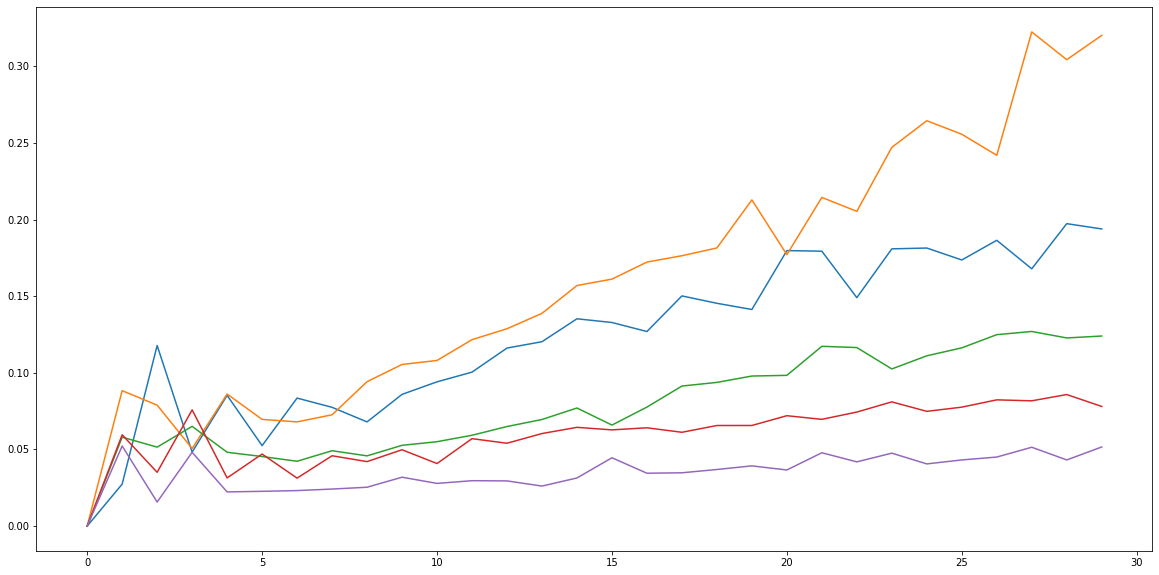

In [14]:
nqfa.params['lr'] = .01
for i in range(5):
  durations, losses = evaluate_learner(nqfa)
  plt.plot(np.array(losses) / np.mean(durations))
plt.show()

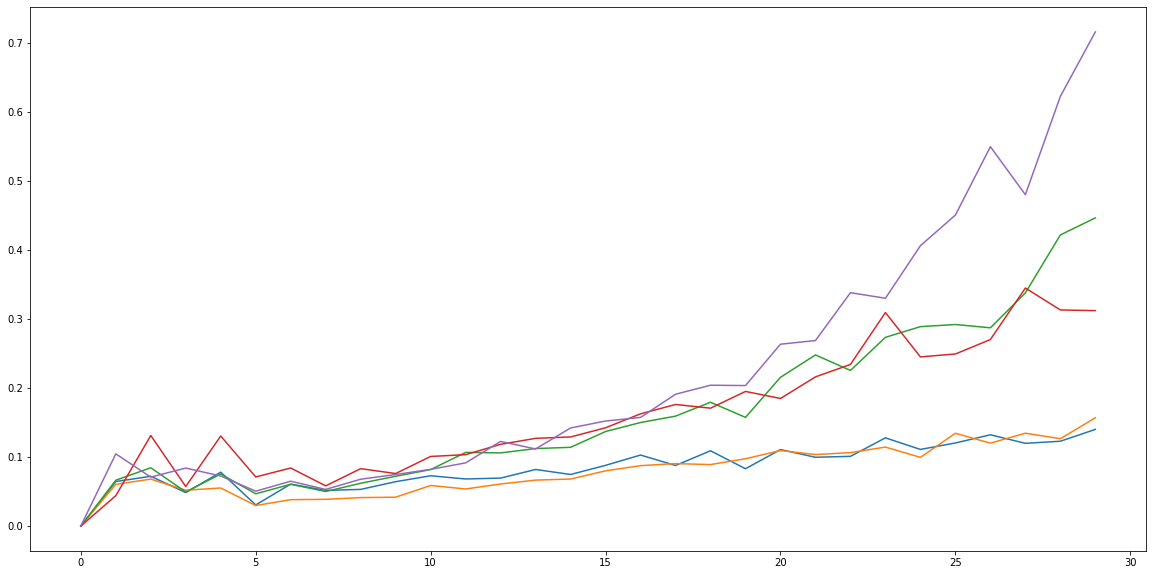

In [23]:
nqfa.params['lr'] = .005
for i in range(5):
  durations, losses = evaluate_learner(nqfa)
  plt.plot(np.array(losses) / np.mean(durations))
plt.show()

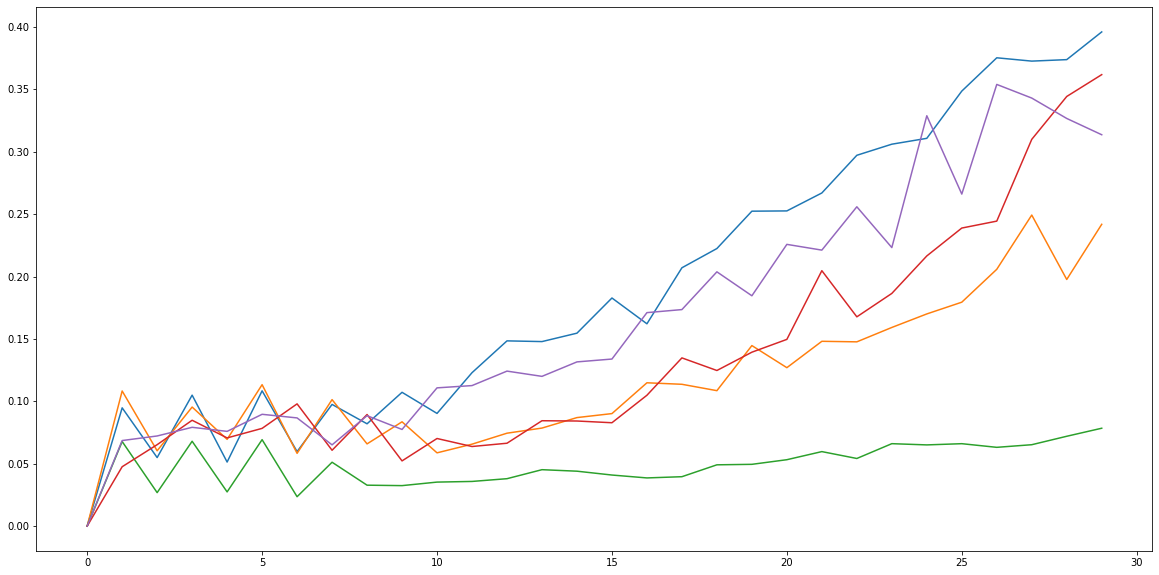

In [24]:
nqfa.params['lr'] = .003
for i in range(5):
  durations, losses = evaluate_learner(nqfa)
  plt.plot(np.array(losses) / np.mean(durations))
plt.show()

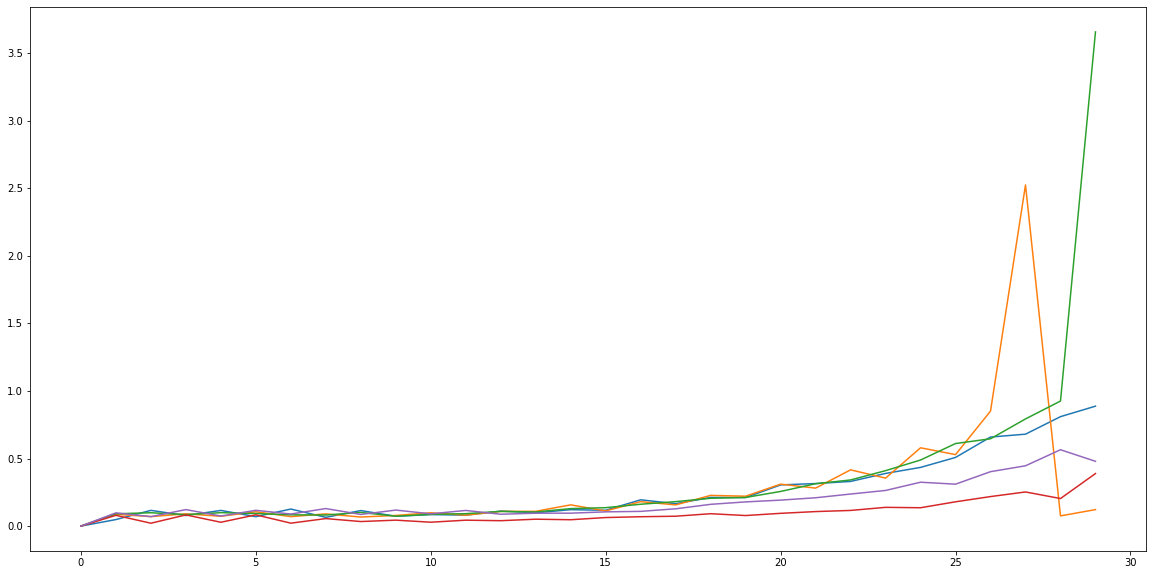

In [25]:
nqfa.params['lr'] = .002
for i in range(5):
  durations, losses = evaluate_learner(nqfa)
  plt.plot(np.array(losses) / np.mean(durations))
plt.show()

### Performance on the task

Without any further tuning

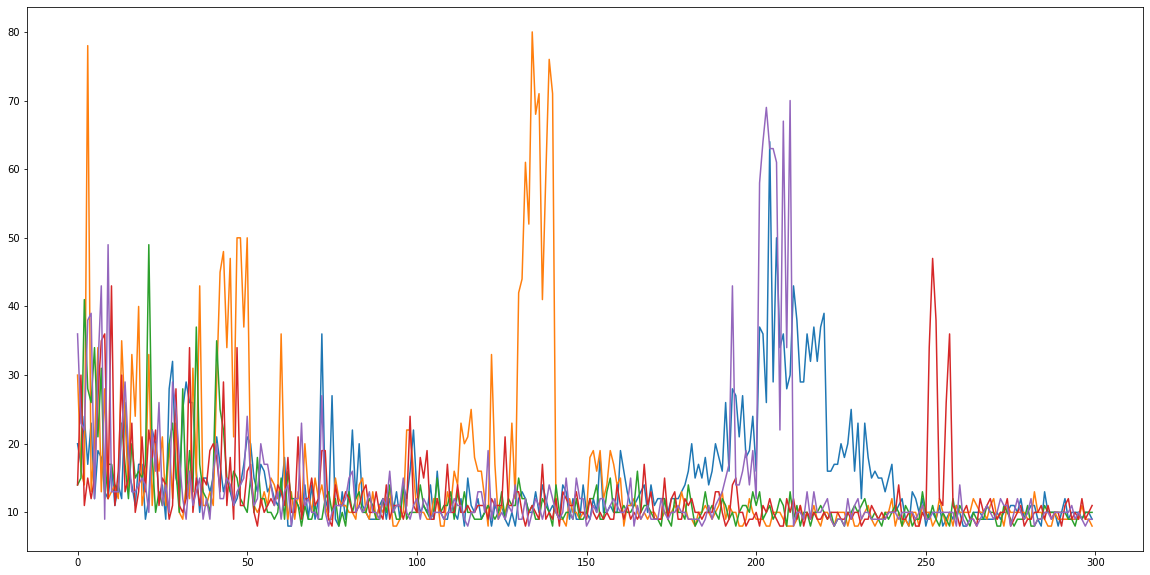

13.743333333333334

In [26]:
nqfa.params['lr'] = .01
for i in range(5):
  durations, losses = evaluate_learner(nqfa)
  plt.plot(durations)
plt.show()
np.mean(durations)

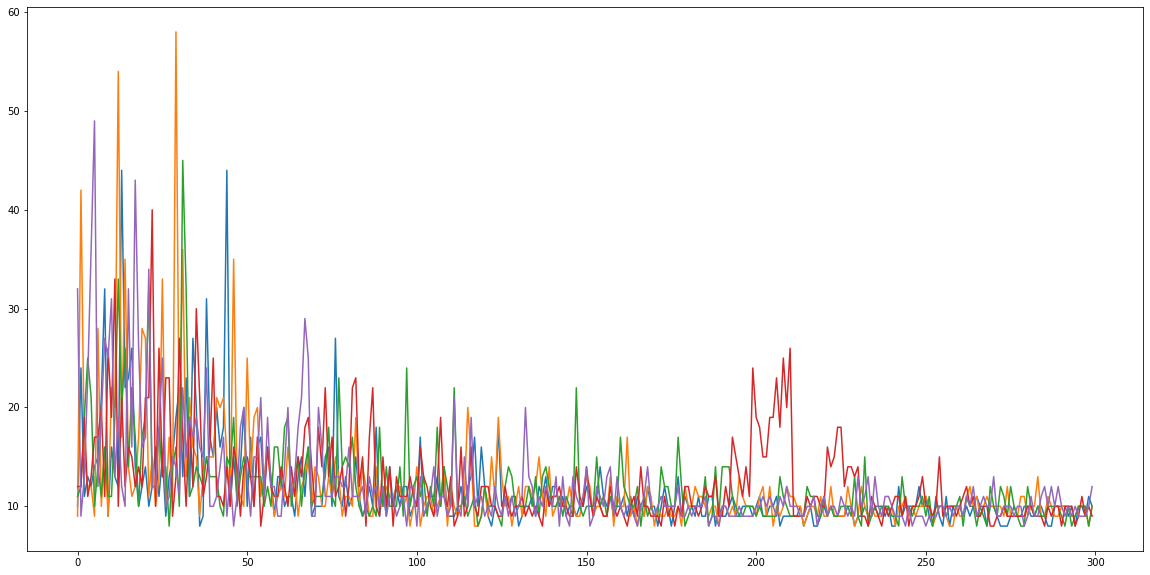

12.113333333333333

In [27]:
nqfa.params['lr'] = .005
for i in range(5):
  durations, losses = evaluate_learner(nqfa)
  plt.plot(durations)
plt.show()
np.mean(durations)

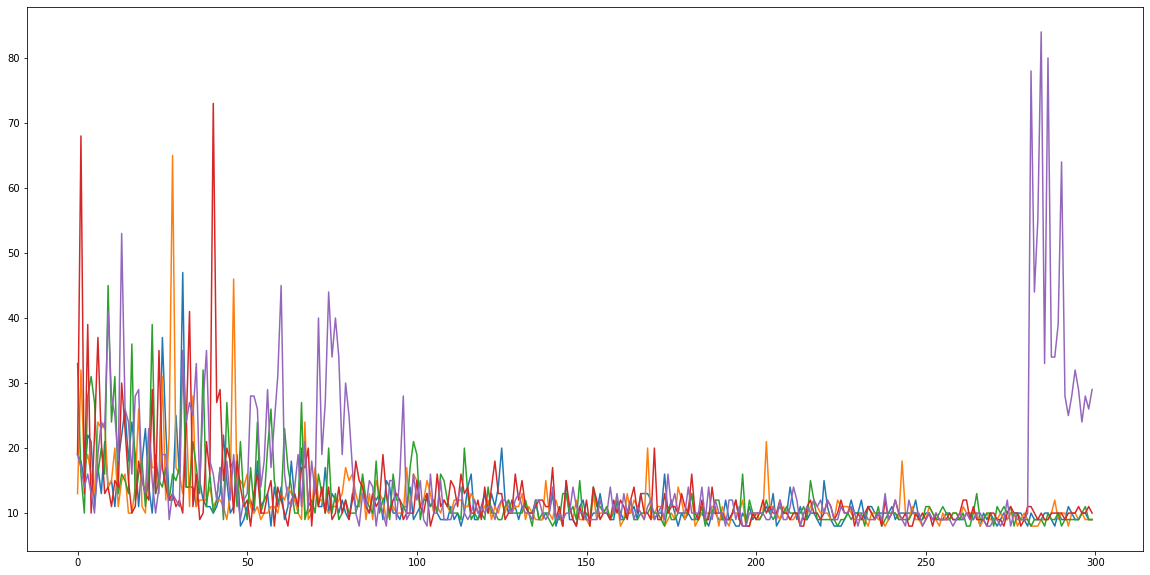

15.42

In [28]:
nqfa.params['lr'] = .003
for i in range(5):
  durations, losses = evaluate_learner(nqfa)
  plt.plot(durations)
plt.show()
np.mean(durations)

**Baseline**

21.636666666666667

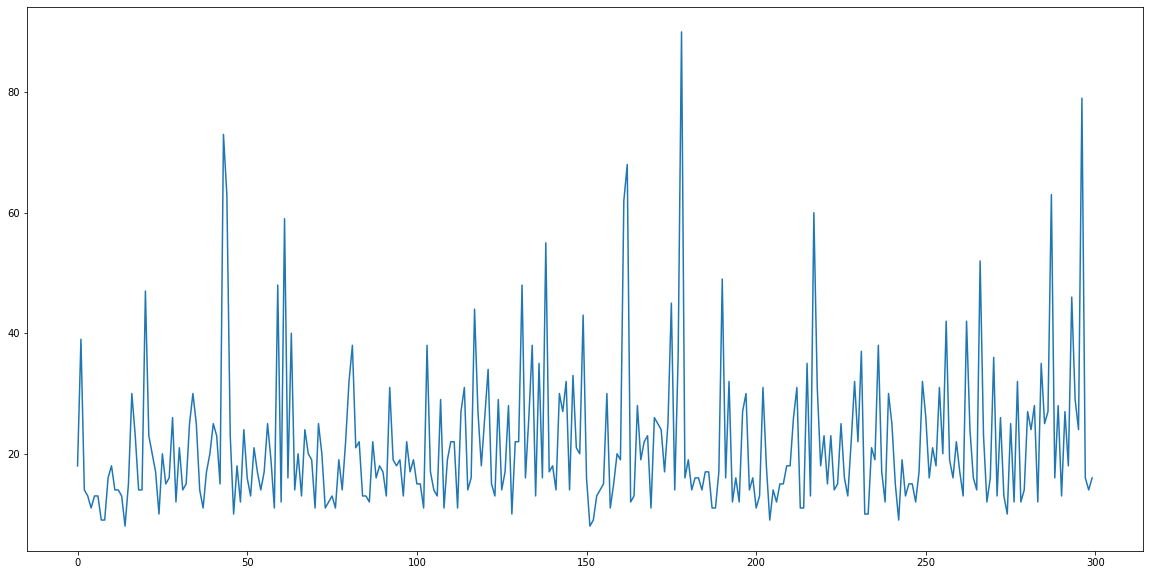

In [29]:
nqfa.params['max_epochs'] = 0
EPS_END = 1.0
for i in range(5):
  durations, losses = evaluate_learner(nqfa)
plt.plot(durations)
np.mean(durations)

These result are not great. It seems to be learning, but then forgets it instead of refining.

### Smarter initialisation

In the below tests I've used a basic heuristic to use instead of random movements at first. If the problem was that with higher scores data was becoming inconsistent (i.e. similar states were remembered with a low value from beginning and a higher value later), that should improve it.

In [0]:
# reset
nqfa.params['max_epochs'] = 2
EPS_END = 0.00

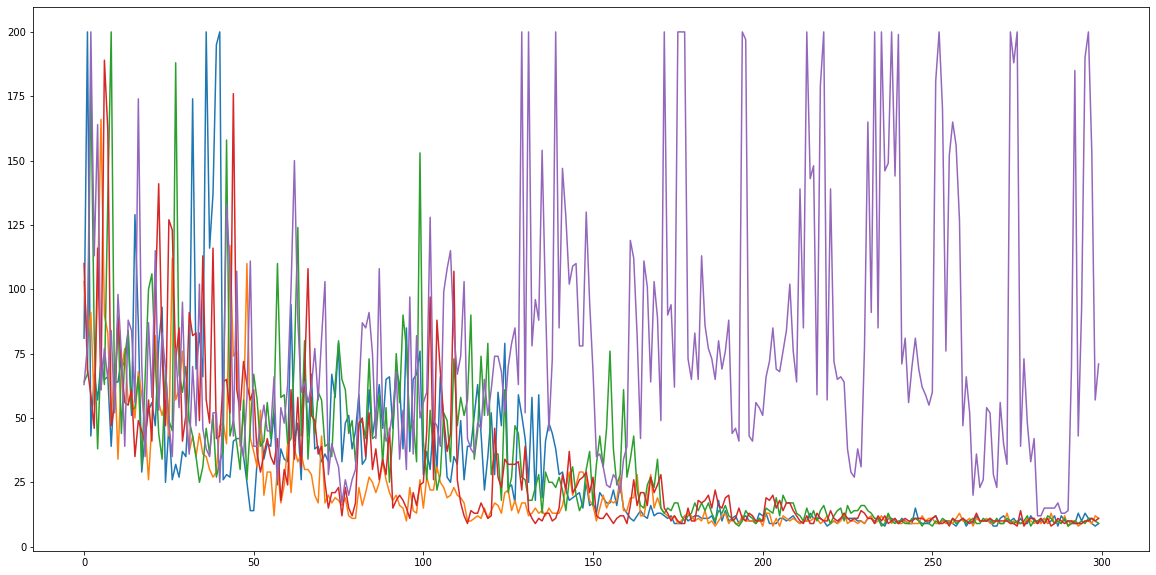

78.73666666666666

In [31]:
nqfa.params['lr'] = .01
for i in range(5):
  durations, losses = evaluate_learner(nqfa, exploration='smart')
  plt.plot(durations)
plt.show()
np.mean(durations)

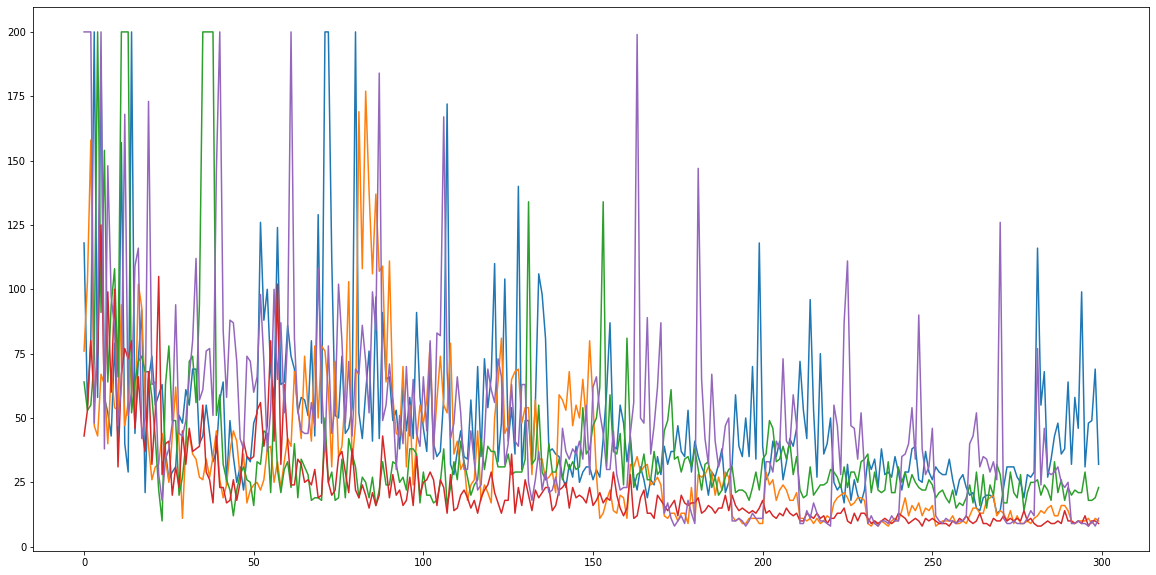

48.586666666666666

In [32]:
nqfa.params['lr'] = .005
for i in range(5):
  durations, losses = evaluate_learner(nqfa, exploration='smart')
  plt.plot(durations)
plt.show()
np.mean(durations)

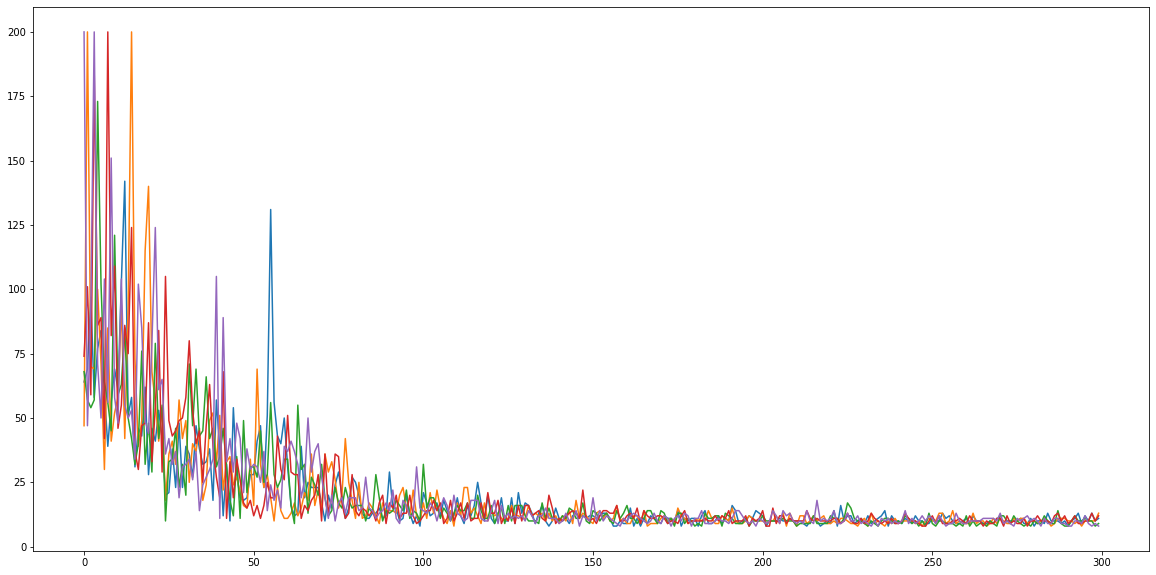

20.75

In [33]:
nqfa.params['lr'] = .003
for i in range(5):
  durations, losses = evaluate_learner(nqfa, exploration='smart')
  plt.plot(durations)
plt.show()
np.mean(durations)

In [34]:
nqfa.memory['states'].std(axis=0)

tensor([0.0915, 0.2307, 0.0656, 0.3110], device='cuda:0')

There is a moderate improvement, but certainly it's not satisfactory.

## XGB

It's possible that a neural net had a problem because Q* is not differentiable.

Why is that? If, from a state, it's possible to survive its value is ~200

If it's deterministically certain it's not possible - value is ~0.

And clearly (possible/not possible) classification over the state space has a sharp boundary.

In [0]:
def bst_fit(target_bst, memory, params):
  train_i, eval_i = next(ShuffleSplit(1, .2).split(memory['states']))
  batch_size = params['batch_size']

  non_final_next_state_mask = (~torch.isnan(memory['next_states']).max(1)[0].to(torch.bool)).cpu().numpy()
  # bootstrap
  next_state_values = torch.ones(non_final_next_state_mask.shape, device=device) * params['death_reward']      
  left_vals = target_bst.predict(xgb.DMatrix(
      np.concatenate((memory['next_states'][non_final_next_state_mask].cpu().numpy(), np.zeros((non_final_next_state_mask.sum(), 1))), 1)
      ))
  right_vals = target_bst.predict(xgb.DMatrix(
      np.concatenate((memory['next_states'][non_final_next_state_mask].cpu().numpy(), np.ones((non_final_next_state_mask.sum(), 1))), 1)
      ))
  # target
  next_state_values[non_final_next_state_mask].shape
  next_state_values[non_final_next_state_mask] = torch.tensor(np.stack((left_vals, right_vals)).max(1)[0])
  expected_state_action_values = ((next_state_values * params['gamma']) + memory['rewards'])  # y ~true
  
  X, y = torch.cat((nqfa.memory['states'], nqfa.memory['actions'].to(torch.float)), 1).cpu().numpy(), expected_state_action_values
  dtrain = xgb.DMatrix(X[train_i], y[train_i])
  dval = xgb.DMatrix(X[eval_i], y[eval_i])

  default_params = {'objective':'reg:squarederror', 'eta':0.015, 'max_depth':3, 'subsample':0.8, 'n_estimators':1500, 'tree_method': 'gpu_hist'}
    
  evallist = [ (dtrain, 'train'), (dval, 'eval')]
  num_round = 20
  return xgb.train(default_params, dtrain, num_round, evallist, early_stopping_rounds = 5, verbose_eval = 0)

def bst_init(memory, params):
  train_i, eval_i = next(ShuffleSplit(1, .2).split(memory['states']))

  non_final_next_state_mask = (~torch.isnan(memory['next_states']).max(1)[0].to(torch.bool)).cpu().numpy()
  # bootstrap
  next_state_values = np.ones(len(memory['states'])) * params['death_reward']      
  # target
  next_state_values[non_final_next_state_mask] = np.random.normal(50, 25, (non_final_next_state_mask.sum(),))
  expected_state_action_values = ((next_state_values * params['gamma']) + memory['rewards'].cpu().numpy())  # y ~true
  
  X, y = torch.cat((nqfa.memory['states'], nqfa.memory['actions'].to(torch.float)), 1).cpu().numpy(), expected_state_action_values
  dtrain = xgb.DMatrix(X[train_i], y[train_i])
  dval = xgb.DMatrix(X[eval_i], y[eval_i])

  default_params = {'objective':'reg:squarederror', 'eta':0.3, 'max_depth':3, 'subsample':0.8, 'n_estimators':1500, 'tree_method': 'gpu_hist'}
    
  evallist = [ (dtrain, 'train'), (dval, 'eval')]
  num_round = 20
  return xgb.train(default_params, dtrain, num_round, evallist, early_stopping_rounds = 5, verbose_eval = 0)


class NQFA_BST():  # N of them

  def __init__(self, qfas, params, fa_type='bst'):
    self.models = [None for _ in qfas]
    self.params = params
    self.fa_type = fa_type
    self.n_models = len(qfas)
    self.curr_model = 0
    self.memory = None  # {'states': None, 'actions': None, 'rewards': None, 'next_states': None}
    self.memory_pending = {'states': [], 'actions': [], 'rewards': [], 'next_states': []}
  
  def update(self):  # update memory, fit
    if self.memory is None:
      self.memory = dict()
      for key in self.memory_pending.keys():  # this is why I chose dict over namedtuple
        self.memory[key] = torch.cat(self.memory_pending[key]).to(device)
    else:
      for key in self.memory_pending.keys():
        self.memory[key] = torch.cat(self.memory_pending[key] + [self.memory[key]]).to(device)
    for key in self.memory_pending.keys():
      self.memory[key] = self.memory[key][-self.params['memory_limit']:]

    if self.models[0] is None:  # first one
      self.models[0] = bst_init(self.memory, self.params)
    else:
      bst = fit(self.fa_type, self.models[self.curr_model], self.memory, self.params)
      self.curr_model = (self.curr_model + 1) % self.n_models
      self.models[self.curr_model] = bst

  def memorize(self, state, action, reward, next_state):
    assert state.shape[0] == 1 and action.shape == (1,1) and reward.shape == (1,) and next_state.shape[0] == 1
    self.memory_pending['states'] += [state.to(device)]
    self.memory_pending['actions'] += [action.to(device)]
    self.memory_pending['rewards'] += [reward.to(device)]
    self.memory_pending['next_states'] += [next_state.to(device)]
  
  def decide(self, state):  # greedy action
    if self.models[0] is None:
      return torch.tensor(np.random.randint(2)).view(1,1)
    else:
      state = state.cpu().numpy()
      state_2 = np.concatenate((
        np.concatenate((state, [[0]]), 1), np.concatenate((state, [[0]]), 1)
      ))
      dstate = xgb.DMatrix(state_2)
      hm = torch.tensor(self.models[self.curr_model].predict(dstate)).argmax().view(1,1)
      return torch.tensor(self.models[self.curr_model].predict(dstate)).argmax().view(1,1)

  def reset(self):
    self.memory = None  
    self.memory_pending = {'states': [], 'actions': [], 'rewards': [], 'next_states': []}



In [0]:
params['memory_limit'] = 100000
nqfa = NQFA_BST([None], params)






  0%|          | 0/15 [00:00<?, ?it/s]




  7%|▋         | 1/15 [00:40<09:29, 40.66s/it]




 13%|█▎        | 2/15 [01:19<08:42, 40.23s/it]




 20%|██        | 3/15 [01:58<07:56, 39.71s/it]




 27%|██▋       | 4/15 [02:38<07:17, 39.78s/it]




 33%|███▎      | 5/15 [03:17<06:35, 39.51s/it]




 40%|████      | 6/15 [03:55<05:51, 39.08s/it]




 47%|████▋     | 7/15 [04:38<05:22, 40.29s/it]




 53%|█████▎    | 8/15 [05:14<04:33, 39.06s/it]




 60%|██████    | 9/15 [05:52<03:52, 38.83s/it]




 67%|██████▋   | 10/15 [06:29<03:10, 38.06s/it]




 73%|███████▎  | 11/15 [07:09<02:34, 38.68s/it]




 80%|████████  | 12/15 [07:50<01:57, 39.30s/it]




 87%|████████▋ | 13/15 [08:28<01:18, 39.20s/it]




 93%|█████████▎| 14/15 [09:08<00:39, 39.30s/it]




100%|██████████| 15/15 [09:48<00:00, 39.22s/it]


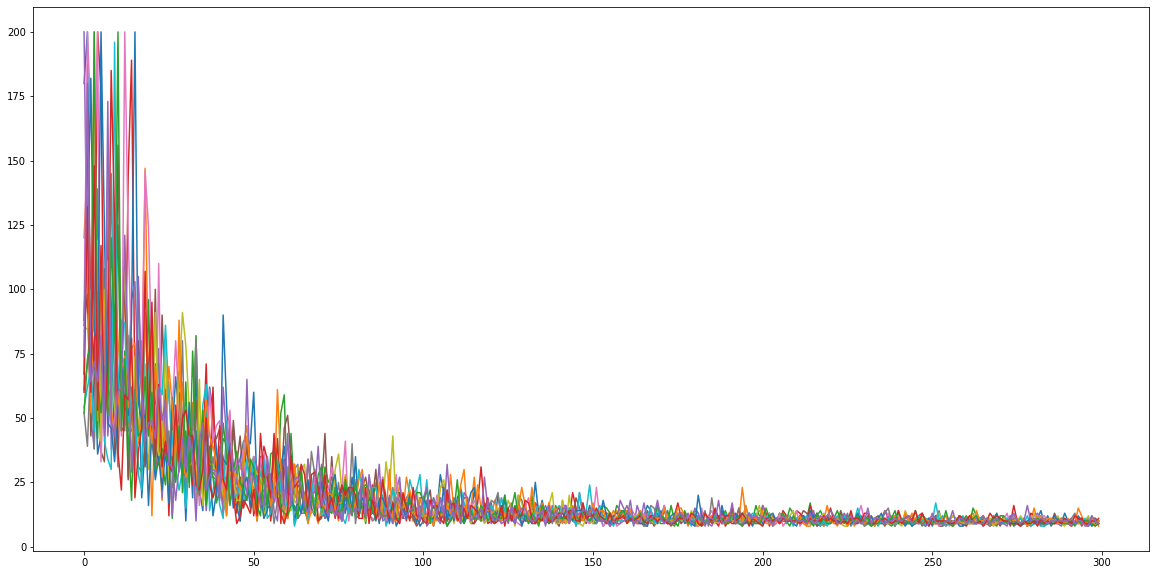

19.186666666666667

In [79]:

for i in trange(15):
  durations_xgb, losses_xgb = evaluate_learner(nqfa, exploration='smart')
  plt.plot(durations_xgb)
plt.show()
np.mean(durations_xgb)

# Conclusions

XGB doesn't work better than a neural net.

One possible reason might be that it's actually preferable for Q functions to have errors, so that they wouldn't overfit for past data.

TODO: find relationship between NN loss and performance of the Q-algorithm based on it.